# Проект: классификация

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
import optuna
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

**Перед нами данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.**

Данные о клиентах банка:
- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:
- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [40]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [41]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [42]:
print(f'Количество пропусков: {df.balance.isna().value_counts()[1]}')

Количество пропусков: 25


В столбце balance есть 25 пропущенных значений. Пропусков мало, лучше удалить эти строки.

### Задание 2

In [43]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Пропущенные значения в признаке job закодированы словом unknown

### Задание 3

In [44]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_to_float(balance):
    """Функция для преобразования признака balance

    Args:
        balance (string): Значение баланса на счёте пользователя

    Returns:
        balance (float): Преобразованное в число значение баланса на счёте пользователя
    """
    if balance is np.nan:
        return np.nan
    else:
        balance = balance.replace(',', '.')
        balance = balance.replace(' ', '')
        balance = balance[0:-1]
        balance = float(balance)
        return balance

df['balance'] = df['balance'].apply(balance_to_float)

# среднее значение по преобразованному признаку balance
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [45]:
# обработайте пропуски в признаки balance, заменив их на медианные значения по данному признаку
df.loc[(df['balance'].isnull()==True),'balance'] = df['balance'].median()

# среднее значение по преобразованному признаку balance
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [46]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

# вычисляем модальное значение для job
mode_of_job = df['job'].mode()[0]

def job_to_mode(job):
    """Функция для преобразования признака job
       Заменяет значение unknown на моду

    Args:
        job (string): Значение признака работы

    Returns:
        job (string): Преобразованное значение признака работы
    """
    if job == 'unknown':
        return mode_of_job
    else:
        return job
    
df['job'] = df['job'].apply(job_to_mode)

###

# вычисляем модальное значение для education
mode_of_education = df['education'].mode()[0]

def education_to_mode(education):
    """Функция для преобразования признака education
       Заменяет значение unknown на моду

    Args:
        education (string): Значение признака образования

    Returns:
        education (string): Преобразованное значение признака образования
    """
    if education == 'unknown':
        return mode_of_education
    else:
        return education
    
df['education'] = df['education'].apply(education_to_mode)

In [47]:
# рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования 
round(df[(df['job'] == mode_of_job) & (df['education'] == mode_of_education)]['balance'].mean(), 3)

1598.883

### Задание 6

Text(0.5, 1.0, 'Распределение баланса клиентов банка')

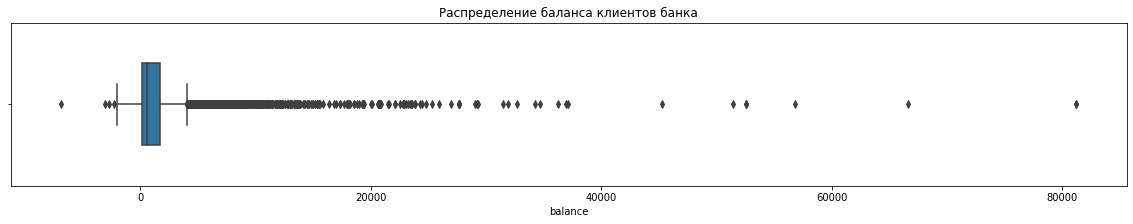

In [48]:
# посмотрим на выбросы в признаке balance
fig = plt.figure(figsize=(20, 3))

boxplot = sns.boxplot(data=df,
                      x='balance',
                      orient='h',
                      width=0.5
                      )

boxplot.set_title('Распределение баланса клиентов банка')

In [49]:
# удалите все выбросы для признака balance

# воспользуемся методом Тьюки сначала для вычисления значений
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return cleaned.shape, lower_bound, upper_bound

print(f'Число значений после очистки: {outliers_iqr(df, "balance")[0][0]}')
print(f'Нижняя граница: {outliers_iqr(df, "balance")[1]}')
print(f'Верхняя граница: {outliers_iqr(df, "balance")[2]}')

# воспользуемся методом Тьюки сначала для вычисления значений
def outliers_iqr_2(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return cleaned

df = outliers_iqr_2(df, 'balance')

Число значений после очистки: 10105
Нижняя граница: -2241.0
Верхняя граница: 4063.0


Text(0.5, 1.0, 'Распределение баланса клиентов банка')

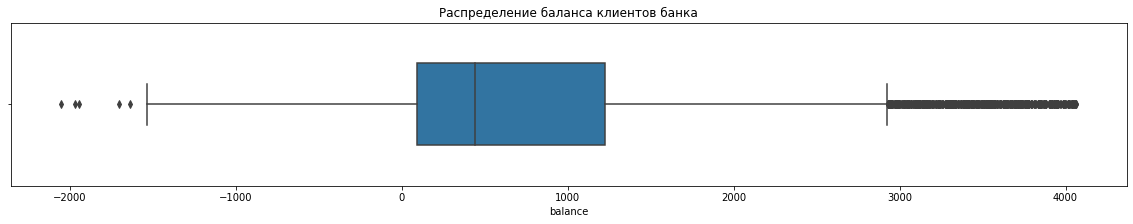

In [50]:
# посмотрим на признак balance ещё раз
fig = plt.figure(figsize=(20, 3))

boxplot = sns.boxplot(data=df,
                      x='balance',
                      orient='h',
                      width=0.5
                      )

boxplot.set_title('Распределение баланса клиентов банка')

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


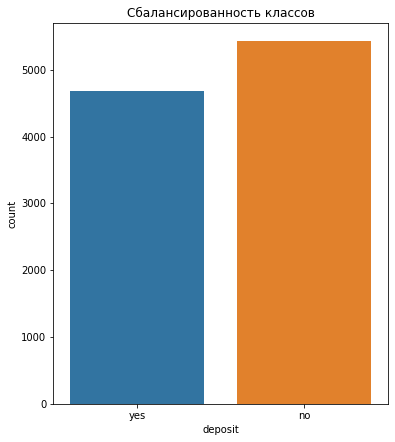

In [51]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = plt.figure(figsize=(6, 7))
countplot = sns.countplot(data=df, x='deposit')
countplot.set_title('Сбалансированность классов')

print(df['deposit'].value_counts())

Разница не более 20%, но этого достаточно, чтобы сделать вывод о необходимости стратификации.

### Задание 2

In [52]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


- Средний и медианный возраст клиентов около 40 лет
- Есть люди, которые имеют отрицательный баланс, но в большинстве случаев баланс положительный
- Звонки клиентам равномерно распределены по дням месяца
- Большинство клиентов поддерживают разговор более 2-3 минут
- Большинству клиентов звонят не более 2-3 раз, однако есть и те, скем общались 43 раза
- Большинство клиентов участвует в маркетинговой компании первый раз

### Задание 3

In [53]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


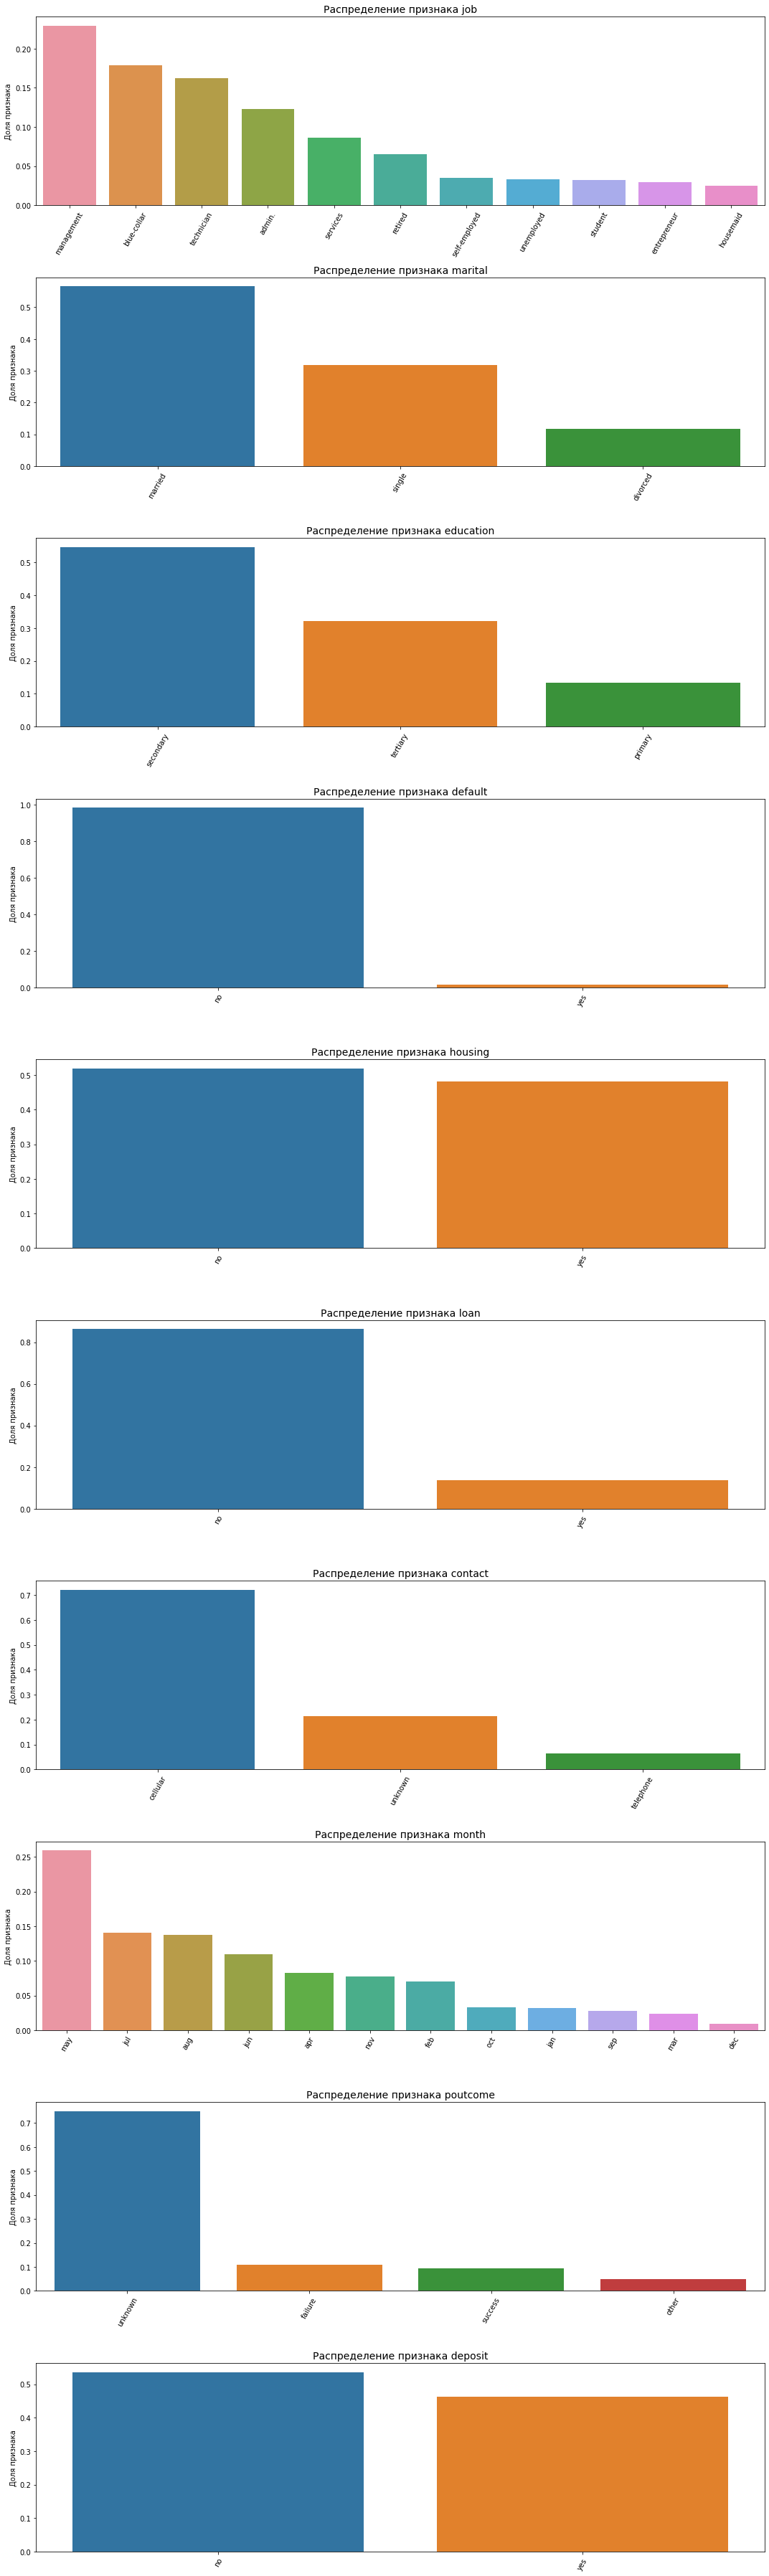

In [54]:
#постройте визуализации, иллюстрирующие результаты

types = df.dtypes
cat_features = list(types[(types == 'object')].index)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, figsize=(15, 50)) #фигура n координатных плоскостей

#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .reset_index())
    
    count_barplot = sns.barplot(data=count_data, x='index', y=feature, ax=axes[i])
    count_barplot.set_title(f'Распределение признака {feature}', fontsize=14)
    count_barplot.set_xlabel('')
    count_barplot.set_ylabel('Доля признака')
    count_barplot.xaxis.set_tick_params(rotation=60)
    
plt.tight_layout() #выравнивание графиков

### Задание 4

In [55]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby(by=['poutcome', 'deposit'])['deposit'].count()

poutcome  deposit
failure   no          562
          yes         547
other     no          216
          yes         265
success   no           84
          yes         861
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Пользователи, относительно которых был достигнут успех в предыдущей кампании, в большей степени показали положительный результат и в текущей кампании.

### Задание 5

In [56]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

# создадим сгруппированную таблицу с результатом и месяцем
df_month = pd.DataFrame(df.groupby(by=['month', 'deposit'])['deposit'].count())
# создадим список для добавления рассчетов
list_of_result = []
# в цикле рассчитаем процент отказов к общему количеству взаимодействий
for i in range(0, 24, 2):
    sum_of_month = df_month.iloc[i][0] + df_month.iloc[i + 1][0]
    result = round((df_month.iloc[i][0] / sum_of_month) * 100, 2)
    list_of_result.append((df_month.iloc[i].name[0], result))
    
list_of_result

[('apr', 38.19),
 ('aug', 55.96),
 ('dec', 9.68),
 ('feb', 45.56),
 ('jan', 60.82),
 ('jul', 58.96),
 ('jun', 54.89),
 ('mar', 10.13),
 ('may', 67.86),
 ('nov', 58.46),
 ('oct', 18.51),
 ('sep', 16.55)]

Наибольший процент отказов зафиксирован в мае

### Задание 6

In [57]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_group(age):
    """Функция для создания нового признака возрастной категории

    Args:
        age (int): Возраст клиента
    
    Returns:
        age_group (int): Значение возрастной группы
        1 - меньше 30 лет
        2 - от 30 до 40 лет
        3 - от 40 до 50 лет
        4 - от 50 до 60 лет
        5 - старше 60 лет
    """
    if age < 30:
        return 1
    elif 30 <= age < 40:
        return 2
    elif 40 <= age < 50:
        return 3
    elif 50 <= age < 60:
        return 4
    else:
        return 5
    
df['age_group'] = df['age'].apply(age_group)

# создадим сгруппированную таблицу с возростными группами и информацией об открытии депозита
df_age_group_deposit = pd.DataFrame(df.groupby(by=['age_group', 'deposit'])['deposit'].count())
# создадим список для добавления рассчетов
list_of_result = []
# в цикле рассчитаем долю открывших депозит к общему количеству клиентов
for i in range(1, 10, 2):
    sum_of_age_group = df_age_group_deposit.iloc[i][0] + df_age_group_deposit.iloc[i - 1][0]
    result = round((df_age_group_deposit.iloc[i][0] / sum_of_age_group) * 100, 2)
    list_of_result.append((df_age_group_deposit.iloc[i].name[0], result))
        
list_of_result

[(1, 59.18), (2, 43.32), (3, 39.38), (4, 40.51), (5, 75.96)]

### Задание 7

Text(0.5, 1.0, 'Распределение результатов маркетинговой кампании в зависимости от семейного положения')

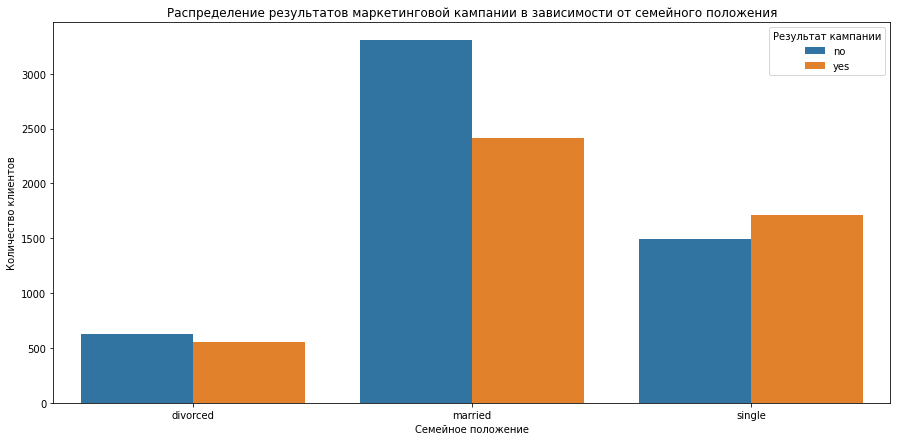

In [58]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

# Группируем данные по семейному положению, результатам маркетинговой кампании и добавляем в DF признак для суммирования значений (любой подойдёт) 
df_of_marital_deposit = df.groupby(by=['marital', 'deposit'], as_index=False)['age'].count()
# Задаем осям и легенде понятные названия
df_of_marital_deposit['Результат кампании'] = df_of_marital_deposit['deposit']
df_of_marital_deposit['Семейное положение'] = df_of_marital_deposit['marital']
df_of_marital_deposit['Количество клиентов'] = df_of_marital_deposit['age']

fig = plt.figure(figsize=(15, 7))

barplot = sns.barplot(data=df_of_marital_deposit,
                      x='Семейное положение',
                      y='Количество клиентов',
                      hue='Результат кампании'
                      )

barplot.set_title('Распределение результатов маркетинговой кампании в зависимости от семейного положения')

Text(0.5, 1.0, 'Распределение результатов маркетинговой кампании в зависимости от образования')

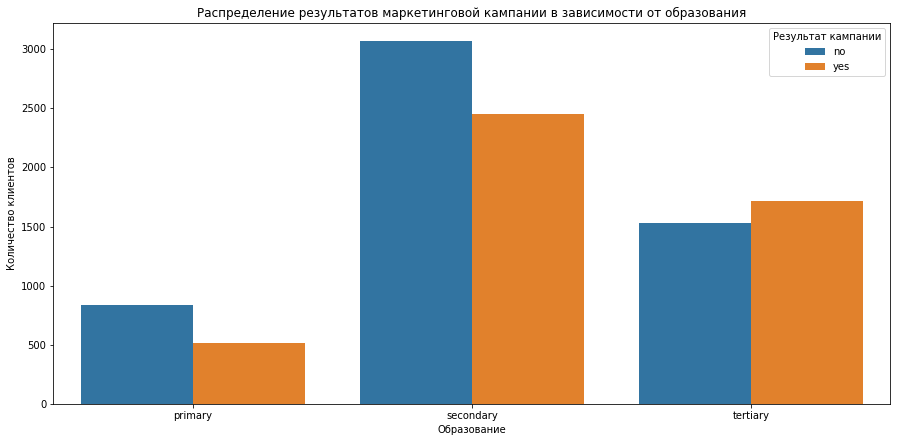

In [59]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

# Группируем данные по образованию, результатам маркетинговой кампании и добавляем в DF признак для суммирования значений (любой подойдёт) 
df_of_education_deposit = df.groupby(by=['education', 'deposit'], as_index=False)['age'].count()
# Задаем осям и легенде понятные названия
df_of_education_deposit['Результат кампании'] = df_of_education_deposit['deposit']
df_of_education_deposit['Образование'] = df_of_education_deposit['education']
df_of_education_deposit['Количество клиентов'] = df_of_education_deposit['age']

fig = plt.figure(figsize=(15, 7))

barplot = sns.barplot(data=df_of_education_deposit,
                      x='Образование',
                      y='Количество клиентов',
                      hue='Результат кампании'
                      )

barplot.set_title('Распределение результатов маркетинговой кампании в зависимости от образования')

Text(0.5, 1.0, 'Распределение результатов маркетинговой кампании в зависимости от образования')

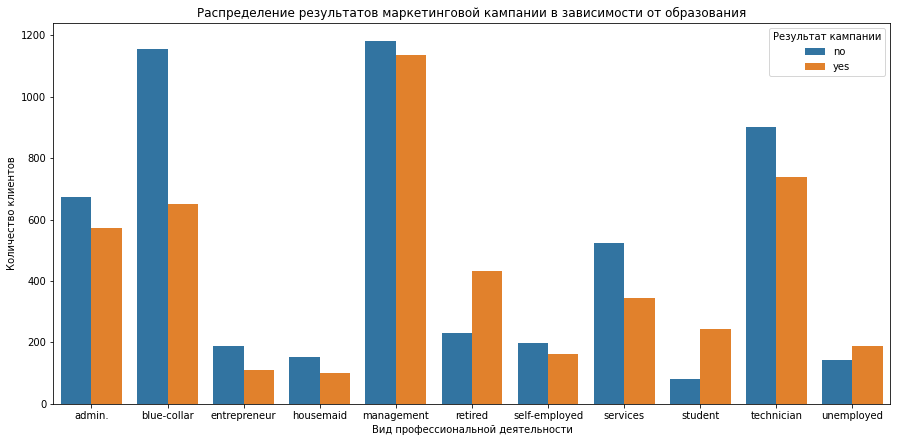

In [60]:
# постройте визуализации для открывших и не открывших депозит в зависимости от вида профессиональной занятости

# Группируем данные по виду профессии, результатам маркетинговой кампании и добавляем в DF признак для суммирования значений (любой подойдёт) 
df_of_job_deposit = df.groupby(by=['job', 'deposit'], as_index=False)['age'].count()
# Задаем осям и легенде понятные названия
df_of_job_deposit['Результат кампании'] = df_of_job_deposit['deposit']
df_of_job_deposit['Вид профессиональной деятельности'] = df_of_job_deposit['job']
df_of_job_deposit['Количество клиентов'] = df_of_job_deposit['age']

fig = plt.figure(figsize=(15, 7))

barplot = sns.barplot(data=df_of_job_deposit,
                      x='Вид профессиональной деятельности',
                      y='Количество клиентов',
                      hue='Результат кампании'
                      )

barplot.set_title('Распределение результатов маркетинговой кампании в зависимости от образования')


### Задание 8

Text(0.5, 1.0, 'Распределение образования и семейного положения среди не открывших депозит клиентов')

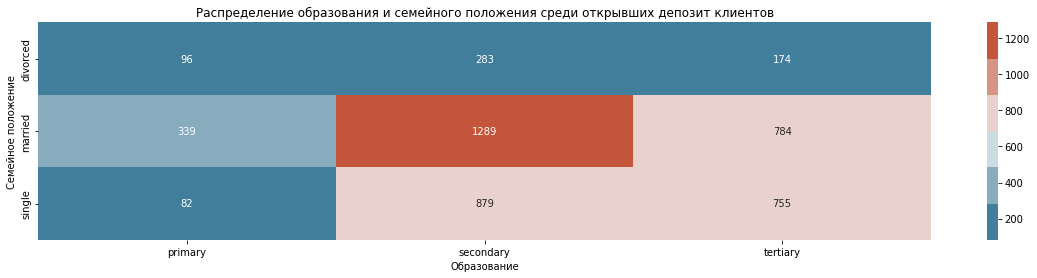

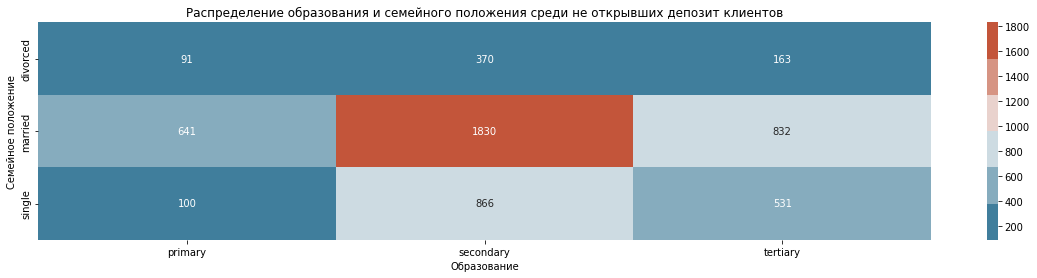

In [61]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны

df_of_marital_eduction = df.groupby(by=['education', 'marital', 'deposit'], as_index=False)['age'].count()

# Задаем осям понятные названия
df_of_marital_eduction['Образование'] = df_of_marital_eduction['education']
df_of_marital_eduction['Семейное положение'] = df_of_marital_eduction['marital']

# создадим сводную таблицу для клиентов открывших депозит
pivot_yes = df_of_marital_eduction[df_of_marital_eduction['deposit'] == 'yes'].pivot_table(values='age', 
                                                                                           index='Семейное положение', 
                                                                                           columns='Образование'
                                                                                          )

fig = plt.figure(figsize=(20, 4))
heatmap_yes = sns.heatmap(data=pivot_yes, annot=True, fmt='.4g', cmap=sns.diverging_palette(230, 20))
heatmap_yes.set_title('Распределение образования и семейного положения среди открывших депозит клиентов')

# создадим сводную таблицу для клиентов не открывших депозит
pivot_no = df_of_marital_eduction[df_of_marital_eduction['deposit'] == 'no'].pivot_table(values='age', 
                                                                                         index='Семейное положение', 
                                                                                         columns='Образование'
                                                                                        )

fig = plt.figure(figsize=(20, 4))
heatmap_no = sns.heatmap(data=pivot_no, annot=True, fmt='.4g', cmap=sns.diverging_palette(230, 20))
heatmap_no.set_title('Распределение образования и семейного положения среди не открывших депозит клиентов')

## Часть 3: преобразование данных

In [62]:
# для начала сделаем копию исходного датасете
df_copy = df.copy()
df_copy.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,4
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,4
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,3


### Задание 1

In [63]:
# преобразуйте уровни образования
le = LabelEncoder()
df_copy['education'] = le.fit_transform(df_copy['education'])
df_copy['education'].sum()

11995

### Задание 2

In [64]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df_copy['deposit'] = df_copy['deposit'].apply(lambda x: 1 if (x == 'yes') else 0)
print(round(df_copy['deposit'].std(), 3))

df_copy['default'] = df_copy['default'].apply(lambda x: 1 if (x == 'yes') else 0)
df_copy['housing'] = df_copy['housing'].apply(lambda x: 1 if (x == 'yes') else 0)
df_copy['loan'] = df_copy['loan'].apply(lambda x: 1 if (x == 'yes') else 0)
print(round(df_copy['default'].mean() + df_copy['loan'].mean() + df_copy['housing'].mean(), 3))

0.499
0.635


### Задание 3

In [65]:
# создайте дамми-переменные
categorial_attributes = ['job', 'marital', 'contact', 'month', 'poutcome']
df_copy = pd.get_dummies(df_copy)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задание 4

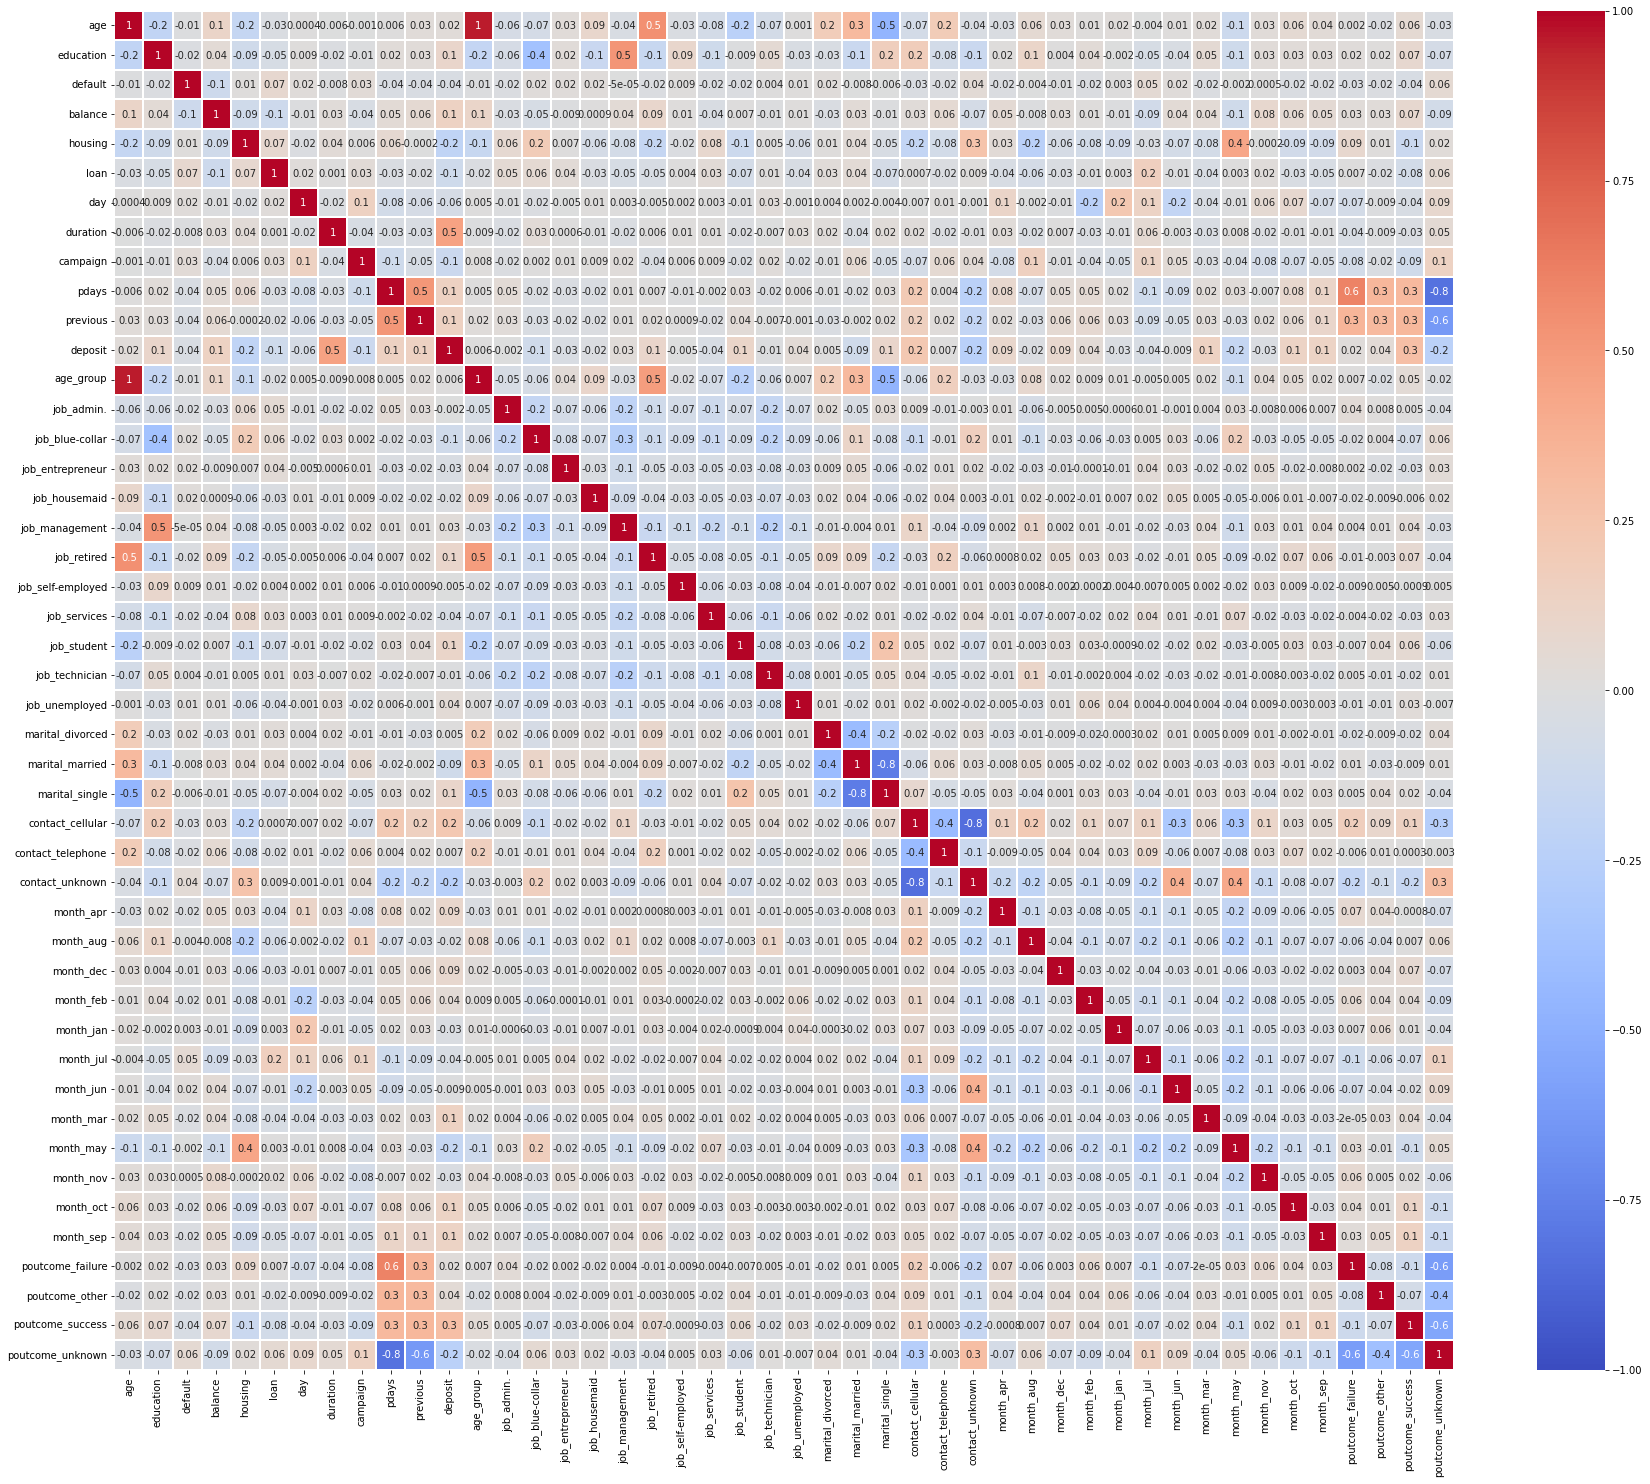

In [66]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30, 25))
_ = sns.heatmap(df_copy.corr(), annot=True, fmt='.1g', cmap='coolwarm', linewidths=0.25, vmin=-1, vmax=1, center= 0)

### Задание 5

Теперь необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33. Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.

In [67]:
X = df_copy.drop(['deposit'], axis=1)
y = df_copy['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [68]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки равен {X_test.shape[0]}')
print(f'Среднее значение целевой переменной на тестовой выборке равно {round(y_test.values.mean(), 2)}')

Размер тестовой выборки равен 3335
Среднее значение целевой переменной на тестовой выборке равно 0.46


### Задание 6

In [69]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
print(selector.get_feature_names_out())

col_names = list(selector.get_feature_names_out())
X_train = X_train[col_names]
X_test = X_test[col_names]

['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 7

In [70]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled , columns=col_names)
X_test_scaled = pd.DataFrame(X_test_scaled , columns=col_names)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [152]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print(f'Accuracy на тестовом наборе: {metrics.accuracy_score(y_test, y_test_pred) :.3f}')

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

Accuracy на тестовом наборе: 0.804


### Задание 2

In [75]:
# обучите решающие деревья, настройте максимальную глубину
des_tr = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

des_tr.fit(X_train_scaled, y_train)
y_train_pred = des_tr.predict(X_train_scaled)
y_test_pred = des_tr.predict(X_test_scaled)

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Можно наблюдать переобучение модели.

### Задание 3

In [141]:
%%time 

# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
             }
            
grid_search_tree = GridSearchCV(estimator=tree.DecisionTreeClassifier(), 
                                param_grid=param_grid, 
                                cv=5,
                                n_jobs=-1
                               )  

grid_search_tree.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_tree.predict(X_test_scaled)

print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.2f}')
print(f'Accuracy на тестовом наборе: {metrics.accuracy_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}')

f1_score на тестовом наборе: 0.79
Accuracy на тестовом наборе: 0.790
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}
Wall time: 260 ms


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [144]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10,
                                     random_state = 42
                                    )

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#делаем предсказание
y_test_pred = rf.predict(X_test_scaled)
#Выводим значения метрики 
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

In [146]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(learning_rate=0.05, #темп обучения
                                         n_estimators=300, #число деревьев
                                         min_samples_leaf=5, #число листьев
                                         max_depth=5, #максимальная глубина дерева
                                         random_state=42 #генератор случайных чисел
                                        )

gb.fit(X_train_scaled, y_train)
y_test_pred = gb.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание3

In [155]:
# объедините уже известные вам алгоритмы с помощью стекинга 

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [('log_reg', linear_model.LogisticRegression(solver='sag', 
                                                          max_iter=1000, 
                                                          random_state=42
                                                         )),  
                          
              ('des_tr', tree.DecisionTreeClassifier(criterion='entropy', 
                                                     max_depth=7, 
                                                     min_samples_split=7,
                                                     random_state=42
                                                    )),
              
              ('gb', ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                                         n_estimators=300,
                                                         min_samples_leaf=5,
                                                         max_depth=5,
                                                         random_state=42
                                                        ))
             ]

#Создаем объект класса стекинг
reg = ensemble.StackingClassifier(estimators=estimators)
#Обучаем модель
reg.fit(X_train_scaled, y_train)
#Делаем предсказание
y_pred_stack = reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задание 4

<AxesSubplot:>

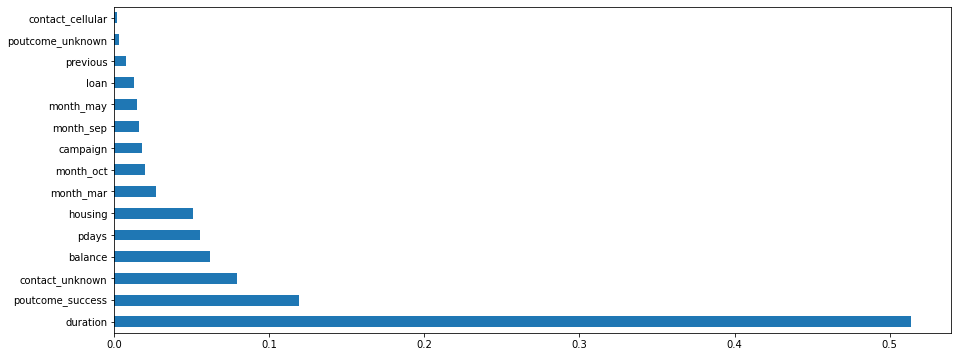

In [160]:
# оцените, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга
plt.rcParams['figure.figsize'] = (15, 6)
feat_importances = pd.Series(gb.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(30).plot(kind='barh')

### Задание 5

In [163]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    # обучаем модель
    model.fit(X_train, y_train)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1', n_jobs=-1).mean()

    return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Accuracy на тестовом наборе: {metrics.accuracy_score(y_test, y_test_pred) :.3f}')

[I 2022-09-02 17:50:11,079] A new study created in memory with name: RandomForestClassifier
[I 2022-09-02 17:50:13,863] Trial 0 finished with value: 0.8186218702500103 and parameters: {'n_estimators': 162, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8186218702500103.
[I 2022-09-02 17:50:17,780] Trial 1 finished with value: 0.8181338756589897 and parameters: {'n_estimators': 168, 'max_depth': 21, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8186218702500103.
[I 2022-09-02 17:50:20,956] Trial 2 finished with value: 0.8186755809289977 and parameters: {'n_estimators': 191, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8186755809289977.
[I 2022-09-02 17:50:23,326] Trial 3 finished with value: 0.8186165616142344 and parameters: {'n_estimators': 189, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8186755809289977.
[I 2022-09-02 17:50:24,632] Trial 4 finished with value: 0.8203269954977609 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 179, 'max_depth': 18, 'min_samples_leaf': 4}
f1_score на тестовом наборе: 0.815
Accuracy на тестовом наборе: 0.825


К сожалению использование стеккинга не принесло прирост метрик. Для рассмотренного примера наиболее эффективным методом является градиентный бустинг и случайный лес, гиперапараметры для модели градиентного бустинга были подобраны с помощью Optuna, что дало небольшой прирост метрик.